<a href="https://colab.research.google.com/github/mynkpl1998/Attention-based-Image-Search/blob/main/Attn_based_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import transforms, datasets
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from tqdm import tqdm
import requests
from tabulate import tabulate
import pickle
import os
import random
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from typing import Any, Callable, List, Optional, Tuple, Union

In [2]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

class Caltech5(Dataset):

  def __init__(self,
               split_ratio: float,
               split: str,
               transform: Optional[Callable] = None,
               target_transform: Optional[Callable] = None):

    super().__init__()

    use_labels = ["motorbikes", "butterfly", "accordion", "airplanes", "brain"]

    assert split == "train" or split == "test"
    self._split_type = split
    assert len(use_labels) == 5
    assert split_ratio > 0.0 and split_ratio <= 1.0

    if transform is not None:
      self._img_transform = transform
    else:
      self._img_transform = None

    img_dims = (300, 300)
    self._base_img_transforms = v2.Compose([
        SquarePad(),
        v2.Resize(img_dims)
    ])

    # Complete 101 dataset
    dataloader = datasets.Caltech101(root="./", download=True)

    # Labels map
    labels_map = {}
    labels_map[3] = "motorbikes"
    labels_map[4] = "accordion"
    labels_map[5] = "airplanes"
    labels_map[13] = "brain"
    labels_map[16] = "butterfly"

    self._labels_map = labels_map

    # label text -> idx
    reverse_label_map = { v:k for k,v in labels_map.items() }
    self._reverse_label_map = reverse_label_map

    # New label mapping
    new_label_map = {}
    new_label_map[3] = 0
    new_label_map[4] = 1
    new_label_map[5] = 2
    new_label_map[13] = 3
    new_label_map[16] = 4
    self._new_label_map = new_label_map

    # Admissible classes
    classes = []

    for l in use_labels:
      classes.append(reverse_label_map[l])

    # Map: class --> Images (list)
    truncated_dataset = {}

    dataset_summary = []
    processed_file = "processed_caltech5.pkl"

    if os.path.exists(processed_file):
      print("Found processed dataset file. Loading.")
      with open(processed_file, 'rb') as f:
        # Unpickle the dictionary
        truncated_dataset = pickle.load(f)
    else:
      print("Creating processed dataset...")
      for idx in tqdm(range(0, len(dataloader))):
        img, label = dataloader[idx]
        if label in classes:
          if label not in truncated_dataset:
            truncated_dataset[label] = []
          truncated_dataset[label].append(img)

      with open(processed_file, 'wb') as f:
        # Pickle the dictionary
        pickle.dump(truncated_dataset, f)
        print("Saved processed dataset.")

    for label_idx in truncated_dataset.keys():
       dataset_summary.append([labels_map[label_idx], len(truncated_dataset[label_idx])])

    print("\n")
    print(tabulate(dataset_summary, headers=["Label", "Num. Examples"]))

    # Split for train and test
    self._train_split, self._test_split = self._split_dataset(truncated_dataset, split_ratio)
    split_summary = []
    split_summary.append(["Train", len(self._train_split)])
    split_summary.append(["Test", len(self._test_split)])
    print("\n")
    print(tabulate(split_summary, headers=["Split Summary", "Num. Examples"]))

  def idx2Label(self, index):
    return self._labels_map[index]

  def _split_dataset(self, dataset, split_ratio):
    train_split = {}
    test_split = {}

    train_examples = 0
    test_examples = 0
    for label_idx in dataset:
      split_index = int(len(dataset[label_idx]) * split_ratio)
      train_data = dataset[label_idx][0:split_index]
      test_data = dataset[label_idx][split_index:]
      train_split[label_idx] = train_data
      test_split[label_idx] = test_data

      train_examples += len(train_data)
      test_examples += len(test_data)

    train_split_merged = self._shuffled_dict_to_list(train_split)
    test_split_merged = self._shuffled_dict_to_list(test_split)

    assert len(train_split_merged) == train_examples
    assert len(test_split_merged) == test_examples

    return train_split_merged, test_split_merged

  def _shuffled_dict_to_list(self, dataset):
    merged_list = []
    for key in dataset.keys():
      for img in dataset[key]:
        merged_list.append((img, key))
    random.shuffle(merged_list)
    return merged_list

  def __repr__(self):
    return "Split: %s\nNum Examples: %d"%(self._split_type, self.__len__())

  def __getitem__(self, idx):

    if self._split_type == "train":
      _split = self._train_split[idx]
    else:
      _split = self._test_split[idx]

    img, class_idx = _split

    # Convert Grayscale to RGB
    if len(img.size) == 2:
      img = img.convert("RGB")

    # Apply padding and reize
    img = self._base_img_transforms(img)

    # Other transforms
    if self._img_transform is not None:
      img = self._img_transform(img)
    return np.moveaxis(np.array(img), -1, 0), self._new_label_map[class_idx]

  def __len__(self):
    if self._split_type == "train":
      return len(self._train_split)
    else:
      return len(self._test_split)


In [3]:
# Data augumentation to apply to image

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomPerspective(distortion_scale=0.4, p=.5),
    v2.RandomInvert(p=0.5),
])

training_data = Caltech5(split_ratio=0.8, split="train", transform=transforms)
''

dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
itr = iter(dataloader)

for idx, (train_features, train_labels) in enumerate(itr):
  #print(idx +1, train_features.shape)
  print(train_labels)
  #break

"""
random_idxs = np.random.randint(0, len(training_data), size=10)
for idx in random_idxs:
  img, _class = training_data[idx]
  label = training_data.idx2Label(_class)
  plt.title(label)
  plt.imshow(img)
  plt.show()
"""

131740031it [00:01, 108072904.33it/s]


Extracting ./caltech101/101_ObjectCategories.tar.gz to ./caltech101


14028800it [00:00, 69470119.12it/s]


Extracting ./caltech101/Annotations.tar to ./caltech101
Creating processed dataset...


100%|██████████| 8677/8677 [00:00<00:00, 9378.61it/s] 


Saved processed dataset.


Label         Num. Examples
----------  ---------------
motorbikes              798
accordion                55
airplanes               800
brain                    98
butterfly                91


Split Summary      Num. Examples
---------------  ---------------
Train                       1472
Test                         370
tensor([0, 0, 2, 0, 4, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 2,
        0, 0, 0, 0, 2, 0, 2, 2])
tensor([0, 0, 2, 4, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 4, 0, 0, 0, 0,
        0, 2, 0, 2, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0,
        2, 2, 2, 2, 0, 3, 2, 0])
tensor([0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 4, 2, 2, 0, 2, 2, 2, 2,
        0, 2, 4, 2, 2, 4, 0, 0])
tensor([3, 0, 0, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 3, 0, 4, 0, 2, 2,
        2, 0, 0, 2, 3, 4, 0, 2])
tensor([0, 1, 0, 2, 4, 0, 0, 4, 0, 0, 2, 0, 4, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0

'\nrandom_idxs = np.random.randint(0, len(training_data), size=10)\nfor idx in random_idxs:\n  img, _class = training_data[idx]\n  label = training_data.idx2Label(_class)\n  plt.title(label)\n  plt.imshow(img)\n  plt.show()\n'

# Fine tune VGG16, Change only last Fully connected layers.

In [4]:
class FinedTunedVGG16(nn.Module):

  def __init__(self):
    super().__init__()

    weights = VGG16_Weights.DEFAULT
    self.vgg16 = vgg16(weights=weights)

    fc = nn.Sequential(
      nn.Linear(in_features=25088, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=4096, bias=True),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5, inplace=False),
      nn.Linear(in_features=4096, out_features=5, bias=True)
    )
    self.vgg16.classifier = fc
    self.vgg16_transforms = VGG16_Weights.IMAGENET1K_V1.transforms()

  def forward(self, x):
    x = self.vgg16_transforms(x)
    return self.vgg16(x)


In [5]:
!nvidia-smi

Sun Nov 12 10:45:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
epochs = 100
bsize = 32
device = "cuda"
lr = 3e-4

model = FinedTunedVGG16()
model.train()

transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomPerspective(distortion_scale=0.4, p=.5),
    v2.RandomInvert(p=0.5),
])

train_dataloader = DataLoader(Caltech5(split_ratio=0.8, split="train", transform=None),
                              batch_size=bsize,
                              shuffle=True)

val_dataloader = DataLoader(Caltech5(split_ratio=0.8, split="test", transform=None),
                            batch_size=bsize,
                            shuffle=True)

model = model.to(device)
criteron = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

def cal_accuracy(preds, targ):
  return torch.sum(preds == targ)/preds.size()[0]

for epoch in range(0, epochs):
  epoch_loss_sum = 0.0
  train_acc_sum = 0.0

  iters = 0

  for (train_x, train_y) in train_dataloader:

    iters += 1

    train_x = train_x.to(device)
    train_y = train_y.to(device)

    # Put model in train mode
    model.train()

    # Get prediction from model
    preds = model(train_x)

    _, pred_tar = torch.topk(preds, 1)
    pred_tar = pred_tar.view(-1)

    # Calculate loss
    loss = criteron(preds, train_y)

    # Calculate Gradients and do backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_loss_sum += loss.item()
    train_acc_sum += cal_accuracy(pred_tar, train_y)


  # Validation Set
  val_iters = 0
  val_epoch_sum = 0.0
  val_acc_sum = 0.0
  model.eval()

  for (val_x, val_y) in val_dataloader:
    val_iters += 1

    val_x = val_x.to(device)
    val_y = val_y.to(device)

    with torch.no_grad():
      pred_val = model(val_x)
      _, val_tar = torch.topk(pred_val, 1)
      val_tar = val_tar.view(-1)

    loss_val = criteron(pred_val, val_y)
    val_epoch_sum += loss_val.item()
    val_acc_sum += cal_accuracy(val_tar, val_y)

  epoch_loss = epoch_loss_sum/iters
  val_epoch_loss = val_epoch_sum/val_iters

  train_acc = train_acc_sum/iters
  val_acc = val_acc_sum/val_iters

  lr_scheduler.step()
  train_loss_hist.append(epoch_loss)
  val_loss_hist.append(val_epoch_loss)
  train_acc_hist.append(train_acc)
  val_acc_hist.append(val_acc)

  #break
  print("Epoch: %d, Train [Acc: %.4f, Loss: %.4f], Val [Acc: %.4f, Loss: %.4f], Lr: %.8f"%(epoch + 1,
                                                                            train_acc,
                                                                            epoch_loss,
                                                                            val_acc,
                                                                            val_epoch_loss,
                                                                            lr_scheduler.get_last_lr()[-1]))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 152MB/s]


Files already downloaded and verified
Found processed dataset file. Loading.


Label         Num. Examples
----------  ---------------
motorbikes              798
accordion                55
airplanes               800
brain                    98
butterfly                91


Split Summary      Num. Examples
---------------  ---------------
Train                       1472
Test                         370
Files already downloaded and verified
Found processed dataset file. Loading.


Label         Num. Examples
----------  ---------------
motorbikes              798
accordion                55
airplanes               800
brain                    98
butterfly                91


Split Summary      Num. Examples
---------------  ---------------
Train                       1472
Test                         370


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1, Train [Acc: 0.8397, Loss: 0.5077], Val [Acc: 0.9225, Loss: 0.1440], Lr: 0.00030000
Epoch: 2, Train [Acc: 0.9273, Loss: 0.2253], Val [Acc: 0.9661, Loss: 0.0998], Lr: 0.00030000
Epoch: 3, Train [Acc: 0.9735, Loss: 0.0844], Val [Acc: 1.0000, Loss: 0.0357], Lr: 0.00030000
Epoch: 4, Train [Acc: 0.9837, Loss: 0.0600], Val [Acc: 0.9583, Loss: 0.2125], Lr: 0.00030000
Epoch: 5, Train [Acc: 0.9124, Loss: 0.4992], Val [Acc: 0.9557, Loss: 0.1273], Lr: 0.00030000
Epoch: 6, Train [Acc: 0.9565, Loss: 0.2124], Val [Acc: 0.9792, Loss: 0.0605], Lr: 0.00030000
Epoch: 7, Train [Acc: 0.9810, Loss: 0.0590], Val [Acc: 0.9896, Loss: 0.0353], Lr: 0.00030000
Epoch: 8, Train [Acc: 0.9857, Loss: 0.0510], Val [Acc: 0.9896, Loss: 0.0194], Lr: 0.00030000
Epoch: 9, Train [Acc: 0.9932, Loss: 0.0203], Val [Acc: 0.9766, Loss: 0.0796], Lr: 0.00030000
Epoch: 10, Train [Acc: 0.9952, Loss: 0.0171], Val [Acc: 0.9902, Loss: 0.0369], Lr: 0.00030000
Epoch: 11, Train [Acc: 0.9925, Loss: 0.0538], Val [Acc: 0.9699, Loss:

KeyboardInterrupt: ignored

In [9]:
val_acc_hist = [a.item() for a in val_acc_hist]

In [11]:
train_acc_hist = [a.item() for a in train_acc_hist]

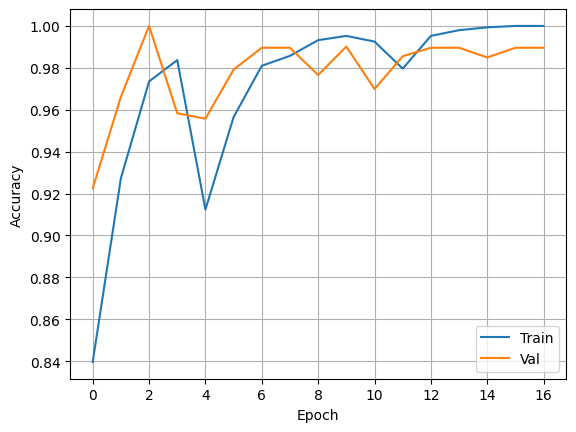

In [14]:
plt.plot(train_acc_hist, label="Train")
plt.plot(val_acc_hist, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

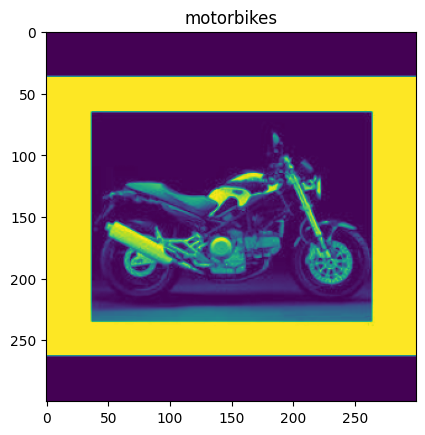

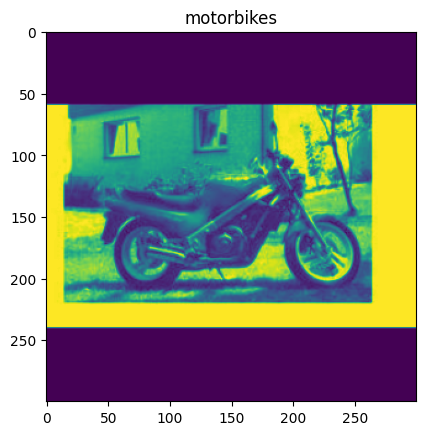

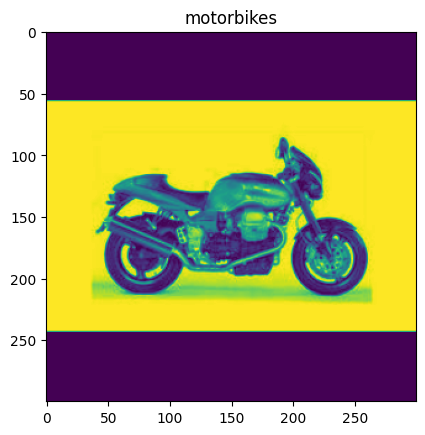

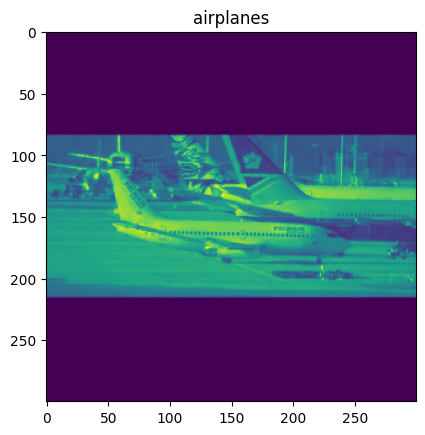

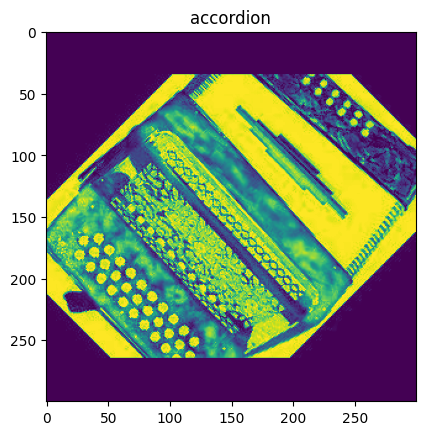

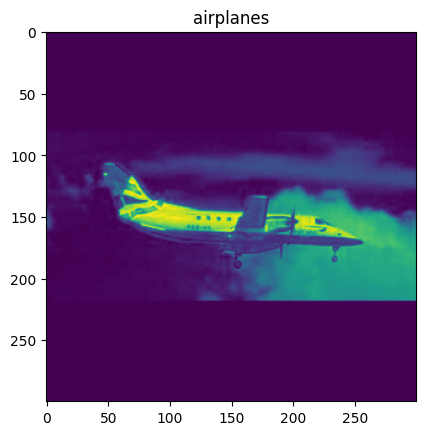

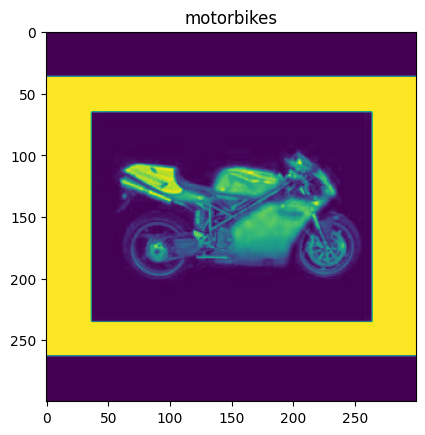

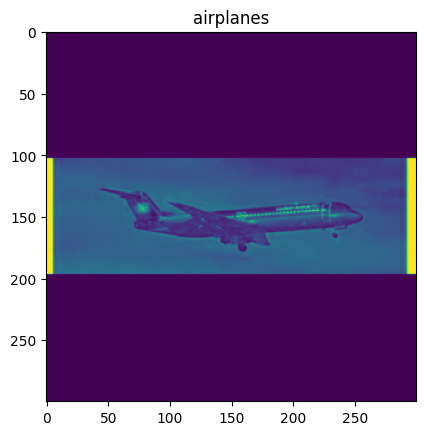

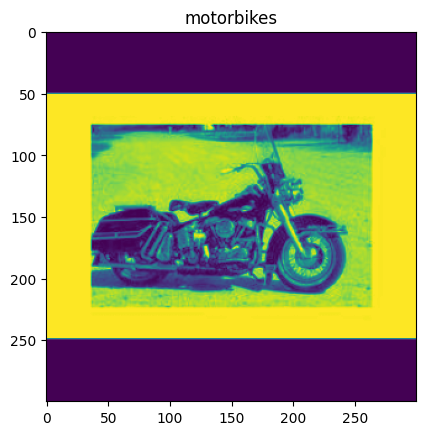

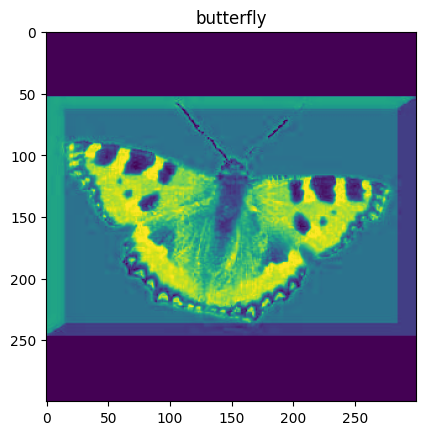

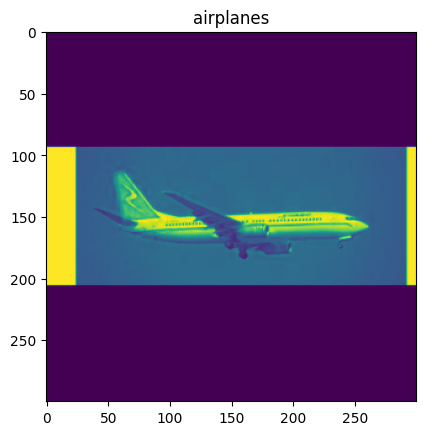

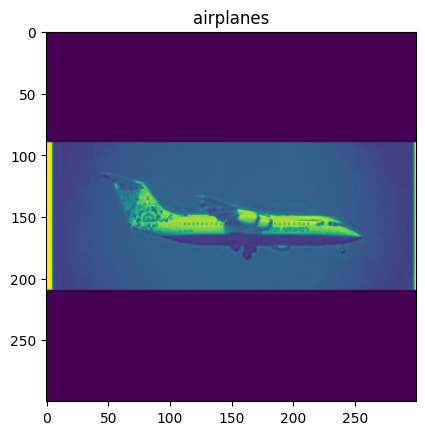

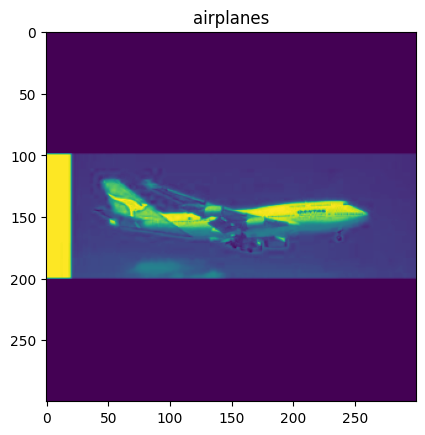

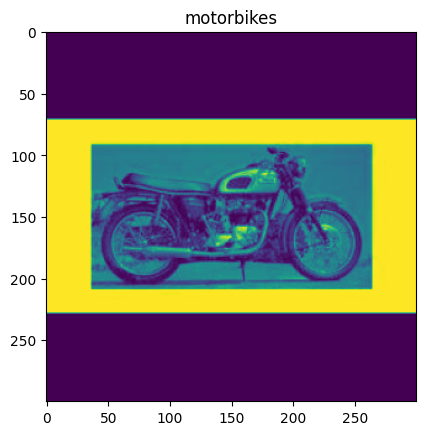

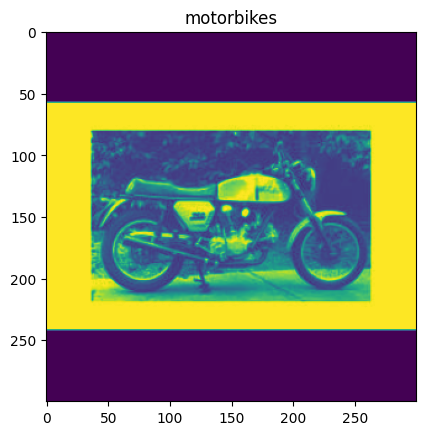

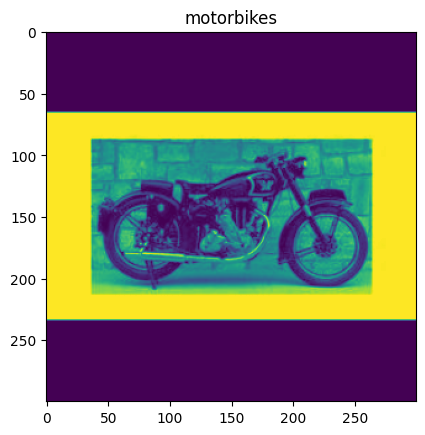

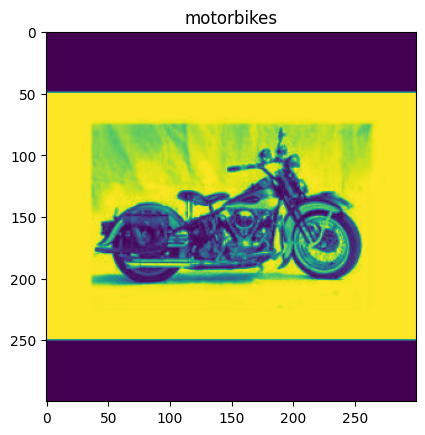

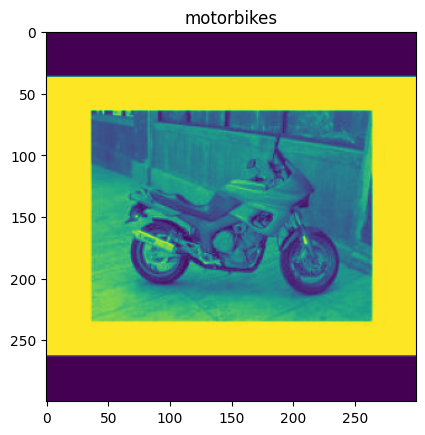

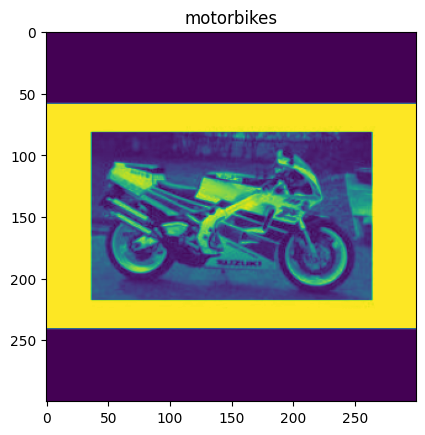

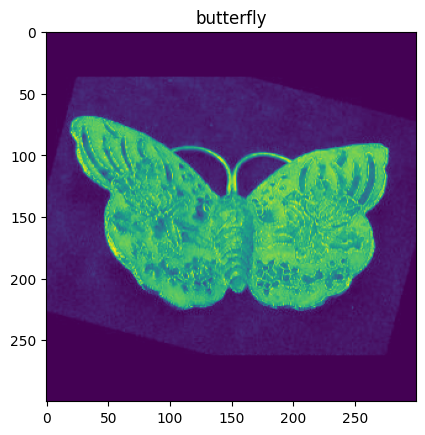

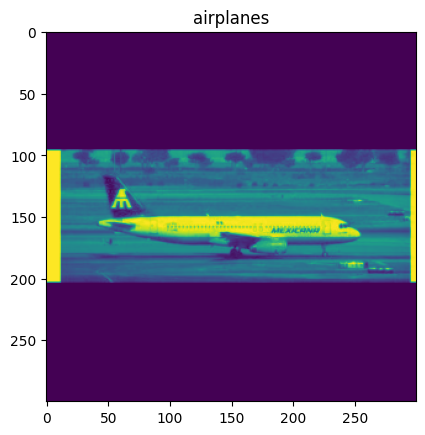

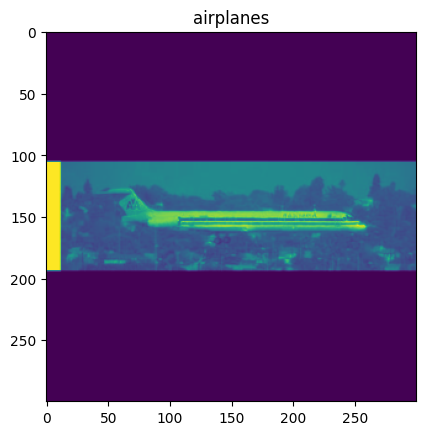

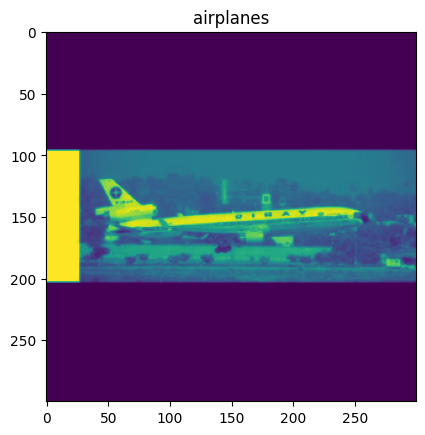

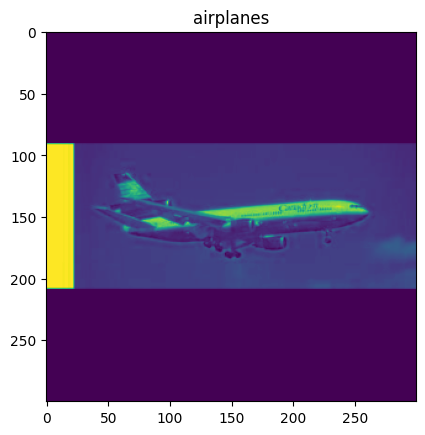

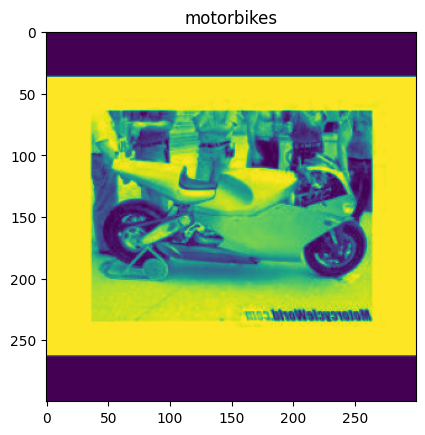

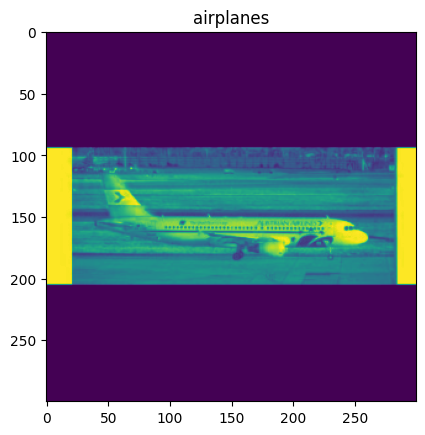

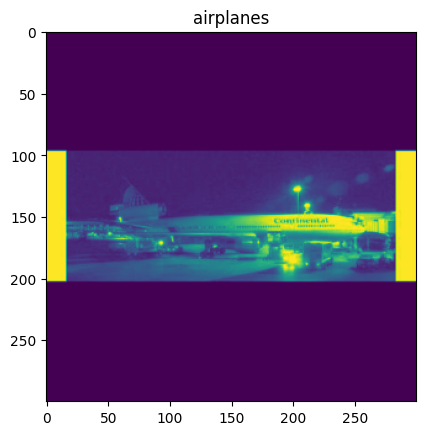

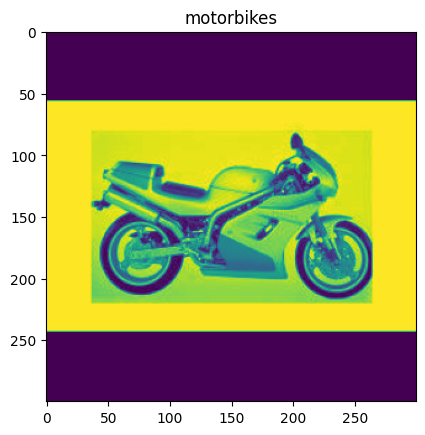

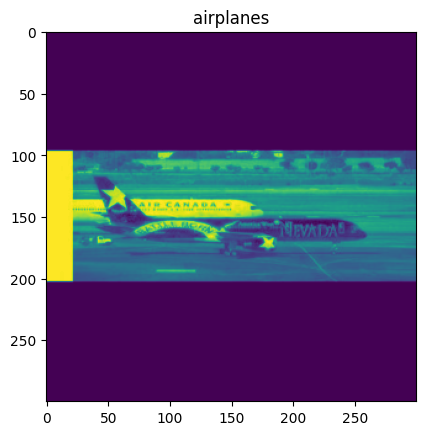

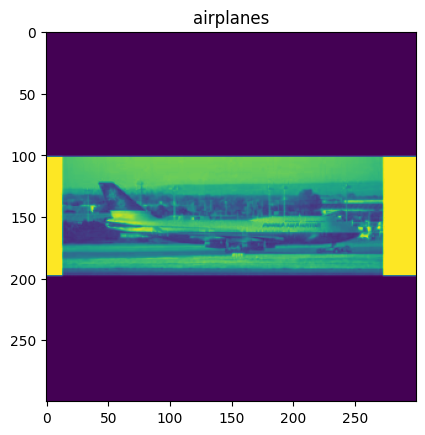

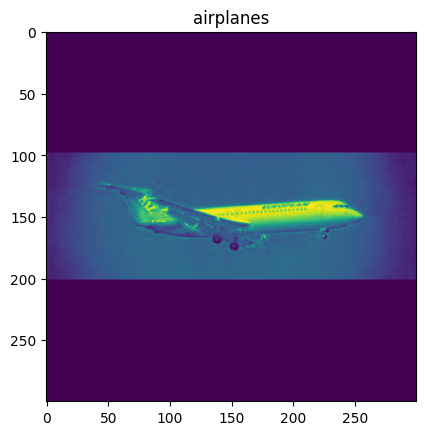

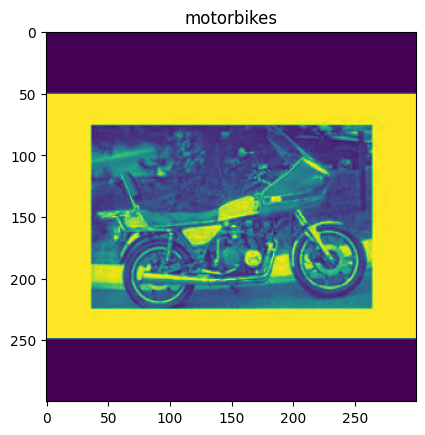

In [34]:
idx = 0
reverse_label_map = { 0 : "motorbikes",
                         1 : "accordion", 2 : "airplanes", 3 : "brain", 4 : "butterfly" }


p_idx = 1

for idx, (val_x, val_y) in enumerate(val_dataloader):

  if p_idx == idx:
    val_x = val_x.to(device)

    model.eval()
    with torch.no_grad():
      pred_val = model(val_x)
      _, probs = pred_val.topk(1)
      probs = probs.view(-1)

      for img,label in zip(val_x, probs):
        title_str = reverse_label_map[label.item()]
        plt.imshow(img[0].cpu().numpy())
        plt.title(title_str)
        plt.show()
    break

In [ ]:
reverse_label_map = { 0 : "motorbikes",
                         1 : "accordion", 2 : "airplanes", 3 : "brain", 4 : "butterfly" }

tensor([ 5,  5, 13,  3,  3,  3,  3,  5,  5,  5,  3,  3,  5, 13, 16,  3,  5,  5,
         5,  5,  3,  3,  3,  3,  5,  3,  5,  3,  5,  5,  3,  5])